<div class='bar_title'></div>

*Introduction to Data Science (IDS)*

# Time Series Analysis

Gunther Gust <br>
Chair for Enterprise AI<br>
Data Driven Decisions (D3) Group<br>
Center for Artificial Intelligence and Data Science (CAIDAS)

<img src='https://github.com/GuntherGust/tds2_data/blob/main/images/d3.png?raw=true' style='width:20%; float:left;' />

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/CAIDASlogo.png" style="width:20%; float:left;" />

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/ao_time_series.png" style="width:80%; float:left;" />

## Time Series Data Is Everywhere

Time series data appears in almost all business and technical domains.

Typical examples include:
- Sales data (daily, weekly, monthly)
- Energy consumption over time
- Stock prices and financial market data

## Why Time Series Data Is Becoming Even More Important

The relevance of time series data will continue to increase.

A key driver is the rapid __growth in the number of sensors__:
- IoT devices in production and logistics
- Smart meters in energy systems
- Real-time monitoring in digital platforms

As a result, more decisions must be made based on **continuous streams of time-dependent data**.


## Applications of Time Series Analysis in Business

| Application | Core Question | Typical Methods | Typical Business Application |
|-------------|---------------|-----------------|------------------------------|
| Forecasting | What will happen next? | Moving averages, ETS, ARIMA/SARIMA, Prophet, ML models | Sales and demand forecasting for planning and budgeting |
| Trend & Seasonality Analysis | What patterns exist over time? | Decomposition (additive/multiplicative), STL, regression with time features | Separating long-term growth from seasonal effects in revenue |
| Anomaly Detection | What is abnormal? | Control charts, residual analysis, STL + thresholds, Isolation Forest | Detecting machine failures, fraud, or data quality issues |
| Change Point Detection | When did behavior change? | CUSUM, Bayesian change point models, structural break tests | Measuring impact of price changes or marketing campaigns |
| Monitoring & Control | Are we still on track? | EWMA charts, rolling statistics, KPI dashboards | Continuous monitoring of operational or financial KPIs |
| Scenario Analysis & Simulation | What could happen under uncertainty? | Time series simulation, bootstrapping, Monte Carlo methods | Risk analysis for demand peaks or financial stress testing |
| Similarity & Segmentation | Which time series behave alike? | DTW, clustering, feature-based similarity | Grouping stores, products, or customers by demand patterns |


# Exercise

Below you see a chart on monthly sales of a certain drug. Based on the observed sales development, you should provide __two forecasts:__

1. What amount of sales do you expect for __January 2008__?
2. What amount of sales do you expect for __February 2008__?

Answer on [Mentimeter](https://www.menti.com/alt52pbvq3fz).

In [1]:
import numpy as np
import pandas as pd
from lets_plot import *
LetsPlot.setup_html()
import matplotlib.pyplot as plt

In [2]:
drug_data = pd.read_csv('https://raw.githubusercontent.com/vhaus63/ids_data/refs/heads/main/drug_sales.txt', sep=",", header=0, parse_dates=['date'], index_col='date') 
drug_df = drug_data.reset_index()

In [3]:
drug_df_plot = drug_df[
    ~drug_df['date'].dt.year.isin([2007, 2008])
]

(
    ggplot(drug_df_plot, aes(x='date', y='value'))
    + geom_line()
    + ggtitle("Drug Sales")
    + scale_x_datetime(
        limits=(drug_df['date'].min(), pd.Timestamp("2008-12-31"))
    )
    + scale_y_continuous(limits=(0, 30) )
    + ggsize(1000, 400)
    
)



> The drug sales time series is dominated by a __trend__ and a __seasonality.__ 

Time series analysis is all about modeling __trends, seasonalities, and noise__ - and to derive associated insights. We will see this in the remainder of this lecture.

# Agenda for today

- Definition: time series
- Descriptive Models for time series
- Predictive Models for time series
- Model diagnostics: How to validate a time series model
- Specialized Topics in time series analysis


# Definition

 
A **time series** is a sequence of observations of the **same** variable __indexed by time.__

$ \{y_t\}_{t=1}^T = (y_1, y_2, \dots, y_T) $

where:
- $y_t$ denotes the value of the variable at time $t$
- $t$ is the time index (e.g., day, month, year)
- $T$ is the total number of observations



## Examples
- **Monthly sales of a company**  
  $y_t$ = total sales in month $t$

- **Daily electricity consumption**  
  $y_t$ = energy usage on day $t$

- **Stock price of a company**  
  $y_t$ = closing price on trading day $t$

- **Website traffic**  
  $y_t$ = number of visitors on day $t$

In all cases, the **same variable** is observed repeatedly over time.

## Key characteristics
- The **variable is fixed** (e.g., sales, demand, price)
- The **time index provides an ordering** of observations
- The **order cannot be changed** without losing information


## Why does order matter? (Example)

Consider monthly sales given by

$ (y_1, y_2, y_3, y_4) = (100, 120, 140, 160) $

- In this order, the data clearly shows a **growing trend**
- If we randomly shuffle the values, for example

$ (140, 100, 160, 120) $

the **trend disappears**, even though the same numbers are used

This shows that in time series analysis, the **ordering of observations contains essential information**.


## Time-series models vs. standard machine learning methods

In most real-world time series applications,

$ y_t \;\text{depends on}\; y_{t-1}, y_{t-2}, \dots $

This means that observations are **not independent**.

> **Contrast to many ML methods:**  
> Most machine learning and classical statistical methods assume that data is **i.i.d.** (independent and identically distributed).  
> Time series data **violates this assumption**, which is why __specialized methods are required.__

# Descriptive Methods for Time Series Analysis

## 1. Visualization


Visualization is the **first and most important step** in time series analysis.  
A simple line plot often reveals more structure than summary statistics.

- Time is shown on the __x-axis__
- The observed variable is shown on the __y-axis__
- Patterns emerge visually before modeling

> Rule of thumb: *Never model a time series you have not plotted.*

## Example: Plotting drug sales

In [4]:
(
    ggplot(drug_df, aes(x='date', y='value'))
    + geom_line()
    + ggtitle("Drug Sales")
    + ggsize(1000, 400)
)

## Business questions this method answers
- How has a business metric developed over time?
- Are there visible **trends**, **seasonal patterns**, or **structural breaks**?
- Are there **outliers** or unusual periods?
- Is the time series **stable or volatile**?

## Typical use cases:
- Sales and revenue monitoring
- Energy consumption tracking
- KPI dashboards
- Early anomaly detection

## 2. Summary statistics

### 2.1 Level measures

Level measures summarize the **central tendency** of a time series.

Common measures:
- **Mean** (average): sensitive to extreme values
- **Median**: robust to outliers

Formally, for a time series $\{y_t\}_{t=1}^T$:

__Mean:__ $ \bar{y} = \frac{1}{T} \sum_{t=1}^T y_t $

__Median:__ The middle value after sorting the observations

> Important:  
> Level measures **ignore time order** — they describe *how high*, not *how it evolves*.

### Business questions level measures can answer

- What is the **typical level** of a KPI over a given period?
- What is a “normal” value for sales, demand, or usage?
- Which product, region, or period operates at a **higher level**?


### 2.2 Variability (Dispersion) Measures

Variability measures describe how strongly observations __fluctuate__ around the level.

Common measures:
- **Variance**
- **Standard deviation**
- **Range** (min–max)

Standard deviation:
$ \sigma = \sqrt{\frac{1}{T} \sum_{t=1}^T (y_t - \bar{y})^2} $

Interpretation:
- Small $\sigma$ → stable process
- Large $\sigma$ → volatile process



### Business questions variability measures can answer
- How **stable or volatile** is the time series?
- How risky or uncertain is demand or revenue?
- How predictable is the business process?

Typical use cases:
- Risk assessment
- Inventory and safety stock planning
- Comparing volatility across products or markets

### 2.3 Relative Variability (Coefficient of Variation)

The **coefficient of variation (CV)** measures variability relative to the mean:

$ CV = \frac{\sigma}{\bar{y}} $

Advantages:
- Scale-independent
- Enables fair comparisons


### Business questions relative variability measures can answer

- Which time series is **more volatile relative to its level**?
- Where is risk highest in relative terms?

Typical use cases:
- Portfolio comparison
- Prioritization of forecasting effort
- Risk-adjusted performance analysis

## 3. Smoothing

A moving average replaces each observation by the **average of the last $k$ values**.

For a window size $k$:

$ MA_t = \frac{1}{k} \sum_{i=0}^{k-1} y_{t-i} $

Effects:
- Random fluctuations are reduced
- Long-term movements become visible
- Larger $k$ → stronger smoothing, slower reaction

In [5]:
# Apply smoothing
drug_df["MA (3 months)"] = drug_df["value"].rolling(window=3).mean()
drug_df["MA (12 months)"] = drug_df["value"].rolling(window=12).mean()

# Convert to long format for ggplot
plot_df = drug_df.melt(
    id_vars="date",
    value_vars=["value", "MA (3 months)", "MA (12 months)"],
    var_name="Series",
    value_name="Sales"
)

# Plot
(
    ggplot(plot_df, aes(x="date", y="Sales", color="Series"))
    + geom_line(size=1)
    + labs(
        title="Drug Sales with Moving Averages",
        y="Sales",
        color="Series"
    )
    + scale_color_manual(values={"Original": "grey", "MA (3 months)": "red", "MA (12 months)": "green"})
    + ggsize(1000, 400)
)

- Grey line: raw data → noisy, hard to interpret
- Red (3 months): reacts quickly, still volatile
- Green (12 months): smooth trend, strong delay

> __Key trade-off:__
> Short window = responsive, 
> Long window = stable but delayed

### Smoothing helps to anwers business questions such as 

- What is the **underlying trend** of the time series?
- How does the business perform **on average**, ignoring short-term noise?
- Is recent performance above or below the long-term level?

Typical use cases:
- Demand smoothing for production planning
- KPI trend monitoring
- Noise reduction in volatile metrics

## 4. Trend Estimation

A trend line approximates the long-term development by a simple function of time, often linear:

$ y_t = a + b \cdot t + \varepsilon_t $

Interpretation:
- $b > 0$: upward trend (growth)
- $b < 0$: downward trend (decline)
- $|b|$: strength of the trend (change per time step)

> Important: A trend line is a **summary** of long-term direction.  
> It does **not** explicitly model seasonality or short-term fluctuations.

In [6]:
# Create a numeric time index t = 0, 1, ..., T-1
drug_df["t"] = np.arange(len(drug_df))

# Fit linear trend: value ≈ a + b * t
b, a = np.polyfit(drug_df["t"], drug_df["value"], deg=1)
drug_df["trend"] = a + b * drug_df["t"]

# Prepare data for plotting (long format)
plot_df = drug_df.melt(
    id_vars="date",
    value_vars=["value", "trend"],
    var_name="Series",
    value_name="Sales"
)

plot_df["Series"] = plot_df["Series"].replace({
    "value": "Original",
    "trend": "Linear trend"
})

# Plot original series + trend line
(
    ggplot(plot_df, aes(x="date", y="Sales", color="Series"))
    + geom_line(size=1)
    + scale_color_manual(values={"Original": "grey", "Linear trend": "#d62728"})
    + labs(
        title="Drug Sales with Linear Trend",
        y="Sales",
        color="Series"
    )
    + ggsize(1000, 400)
)

### Trend estimation to anwers business questions such as

- Is the KPI (e.g., sales) **growing or declining** over time?
- How strong is the **long-term change** (e.g., “+X units per month”)?
- Can we summarize development with a **simple, communicable trend**?

Typical use cases:
- Strategic reporting (“Are we on a growth path?”)
- Comparing growth across products/regions
- Establishing a baseline before modeling seasonality/other effects

##  5. Time Series Decomposition


Time series decomposition splits a time series into interpretable components.

**Additive model** :

$ y_t = T_t + S_t + R_t $

where:
- $T_t$ = trend (long-term development)
- $S_t$ = seasonal component (recurring patterns)
- $R_t$ = residual (noise, unexplained variation)

> Use an additive model when seasonal fluctuations are roughly constant over time.


In a **multiplicative decomposition**, the components interact multiplicatively:

$ y_t = T_t \times S_t \times R_t $

where:
- $T_t$ = trend component
- $S_t$ = seasonal component (interpreted as a *multiplier*)
- $R_t$ = residual component

Interpretation differences to additive decomposition:
- Seasonality is **relative**, not absolute  
- A seasonal value of $S_t = 1.10$ means “10% above trend”
- A value of $S_t = 0.90$ means “10% below trend”

> Rule of thumb:  
> Use a multiplicative model when seasonal swings increase as the series grows.

### Mentimeter

Which decomposition (additive or multiplicative) is more suitable for the drug sales data? 

> Vote on [Mentimeter](https://www.menti.com/alt52pbvq3fz).

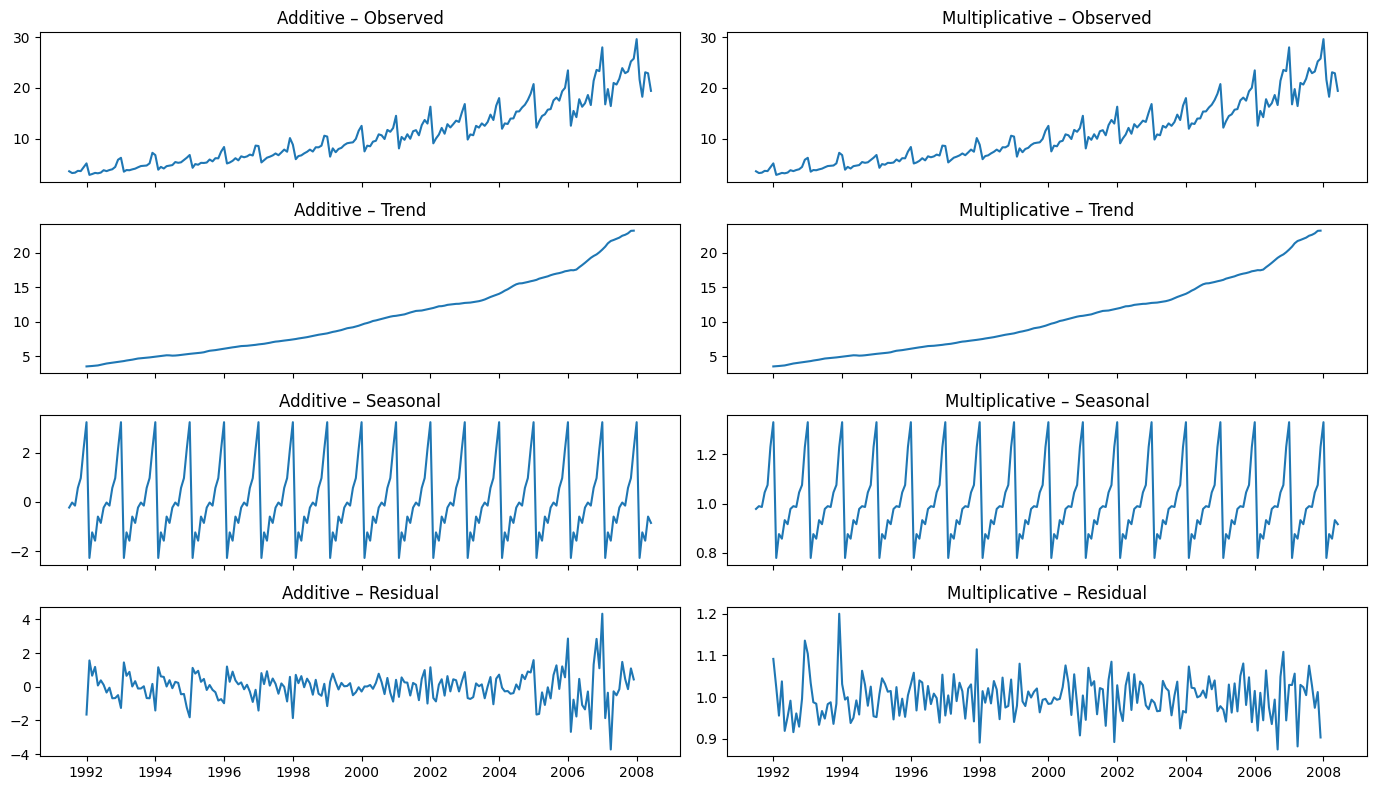

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Set date as index (required)
drug_ts = drug_df.set_index("date")["value"]

# Decompositions
decomp_add = seasonal_decompose(
    drug_ts,
    model="additive",
    period=12
)

decomp_mul = seasonal_decompose(
    drug_ts,
    model="multiplicative",
    period=12
)

# Create side-by-side plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 8), sharex=True)

components = [
    ("Observed", drug_ts),
    ("Trend", decomp_add.trend),
    ("Seasonal", decomp_add.seasonal),
    ("Residual", decomp_add.resid),
]

components_mul = [
    ("Observed", drug_ts),
    ("Trend", decomp_mul.trend),
    ("Seasonal", decomp_mul.seasonal),
    ("Residual", decomp_mul.resid),
]

# Additive (left column)
for i, (name, series) in enumerate(components):
    axes[i, 0].plot(series)
    axes[i, 0].set_title(f"Additive – {name}")

# Multiplicative (right column)
for i, (name, series) in enumerate(components_mul):
    axes[i, 1].plot(series)
    axes[i, 1].set_title(f"Multiplicative – {name}")

plt.tight_layout()
plt.show()


The solution will be discussed in the lecture. If you missed it, look at residuals of the above plots. The section on __model diagnostics__ (later in the script) provides you hints on how to interpret them. 

### Decomposition helps to answer business question such as:
- Which part of the variation is due to **long-term trend**, **seasonality**, or **random noise**?
- Is seasonality **stable and recurring** (e.g. every year)?
- How much of the observed behavior is **systematic vs. unpredictable**?

Typical use cases:
- Sales with strong seasonal patterns
- Energy demand analysis
- Separating strategic (trend) from operational (seasonal) effects
- Preparing data for forecasting models


## Background: How decompositions are computed

### Step 1: Estimating the trend $T_t$

The trend is typically estimated by **smoothing** the series.

Common approaches:
- Moving averages
- Local regression (LOESS)
- Exponential smoothing

Conceptually:
- Short-term fluctuations are averaged out
- What remains is the **long-term movement**

Formally (example: moving average):
$ T_t \approx \frac{1}{k} \sum_{i=-(k-1)/2}^{(k-1)/2} y_{t+i} $

### Step 2: Removing the trend (detrending)

To isolate seasonality, we first remove the trend.

#### Additive case
$ y_t - T_t = S_t + R_t $

#### Multiplicative case
$ \frac{y_t}{T_t} = S_t \times R_t $

This produces a **detrended series**.

### Step 3: Estimating the seasonal component $S_t$

Seasonality is estimated by **averaging over equivalent periods**.

Example: monthly data with yearly seasonality ($s = 12$)

For each month $m$:
- collect all detrended observations for month $m$
- compute their average

Additive seasonality:
$ S_m = \text{average of } (y_t - T_t) \text{ for month } m $

Multiplicative seasonality:
$ S_m = \text{average of } \left(\frac{y_t}{T_t}\right) \text{ for month } m $

The seasonal pattern is then **repeated over time**.

### Step 4: Computing the residuals $R_t$

Finally, the residual component is what remains after removing trend and seasonality.

##### Additive residuals
$ R_t = y_t - T_t - S_t $

##### Multiplicative residuals
$ R_t = \frac{y_t}{T_t \times S_t} $

Interpretation:
- Additive: absolute unexplained variation (around 0)
- Multiplicative: relative unexplained variation (around 1)

## Key Takeaways: Descriptive Methods in Time Series Analysis

- **Descriptive methods are mandatory — not optional**  
  They are the foundation of any serious time series analysis.

- **They help us understand, not predict**  
  Descriptive analysis answers *“What is happening?”*, not *“What will happen?”*.

- **Good visualization beats complex models**  
  A well-chosen plot often reveals more than sophisticated algorithms.

- **Every forecast starts with description**  
  Without understanding structure, forecasts are unreliable.

> **Bottom line:**  
> *If you don’t understand the data, you can’t forecast it.*


# Predictive Models for Time Series Analysis

### Example Task: Predicting Earth Climate

We will work with a timeseries that contains the __global annual temperature anomalies__ provided by the Berkeley Earth Surface Temperature Study. Temperatures are given in Celsius and are reported as anomalies relative to the period __January 1850 to December 2000 average.__



__Task:__ We will try to __predict the future development of the temperature__ based on the given historical data.

In [8]:
t_global = pd.read_csv("https://raw.githubusercontent.com/vhaus63/ids_data/refs/heads/main/temp_ts.csv")
t_global["Date"] = pd.to_datetime(t_global["Date"], format="%Y-%m-%d", errors="coerce")
t_global = t_global.set_index("Date")["Monthly Anomaly_global"]

t_global

Date
1750-01-01   -0.993
1750-02-01   -1.679
1750-03-01   -0.192
1750-04-01   -0.531
1750-05-01   -1.881
              ...  
2022-05-01    1.023
2022-06-01    1.315
2022-07-01    1.289
2022-08-01    1.231
2022-09-01    1.090
Name: Monthly Anomaly_global, Length: 3273, dtype: float64

We see that the data set consist of __monthly__ mean temperatures. In order to see effects over the long period more clearly, we will aggregate the data to a __yearly basis.__

In [9]:
temp_global_year = t_global.groupby(t_global.index.to_period("Y")).agg("mean")

There are several very helpful methods in python for dealing with timeseries. Some of those (like the above `to_period` function) we will already encounter during the course of this notebook. If you want to get further details about __Datetime manipulation,__ Resampling, Shifting, Time Zone handling,..., please refer to [Wes McKinney's Python for Data Analysis (Chapter 11)](https://wesmckinney.com/book/time-series).

In [10]:
temp_global_year_df = pd.DataFrame(temp_global_year).reset_index()
temp_global_year_df['Date'] = temp_global_year_df['Date'].dt.to_timestamp() 

(
    ggplot(temp_global_year_df, aes(x='Date', y='Monthly Anomaly_global'))
    + geom_line()
    + ggtitle("Earth Surface Temperature Anomalies")
    + xlab("Year") + ylab("Temperature Anomaly")
    + ggsize(1000, 400)
)

Now, we split the data set into two parts. One part, the __training set,__ is the period 1850 to 2000. Based on that data set we learn the model parameters. The other part, the __test set,__ is the period 2001 to 2021. This part is used to validate our model, as we compare the model forecast with the observations.

In [11]:
temp_global_training = temp_global_year["1850-01-01":"2000-01-01"]
temp_global_test = temp_global_year["2000-01-01":]

In [12]:
training_df = temp_global_training.reset_index().rename(columns={'Date': 'year'}).assign(label='training set 1850-2000')
test_df = temp_global_test.reset_index().rename(columns={'Date': 'year'}).assign(label='test set 2001-2016')
combined_df = pd.concat([training_df, test_df])
combined_df['year'] = combined_df['year'].dt.to_timestamp()

(
    ggplot(combined_df, aes(x='year', y='Monthly Anomaly_global', color='label'))
    + geom_line()
    + ggtitle("Earth Surface Temperature Anomalies")
    + xlab("Year") + ylab("Temperature Anomaly")
    + ggsize(1000, 400)
)

Now, let's try to __predict__ the values in the __test set__, using the __most common time series models.__

## 1. Naive model (baseline)

The **naive model** assumes that the best prediction for the next period is the **last observed value**.

Formally:

$ \hat{y}_{t+1} = y_t $

Assumptions:
- No systematic trend or seasonality
- Strong short-term persistence

Why this model matters:
- Serves as a **baseline**
- Any useful model must outperform it

In [13]:
# helper function for plotting
def plot_forecast(training_df, test_df, forecast_col, title):
    
    plot_df = pd.concat([
        training_df.assign(Series="Training data")[["year", "Monthly Anomaly_global", "Series"]],
        test_df.assign(Series="True (test)")[["year", "Monthly Anomaly_global", "Series"]],
        test_df.assign(Series="Forecast")[["year", forecast_col, "Series"]]
              .rename(columns={forecast_col: "Monthly Anomaly_global"})
    ], ignore_index=True)

    p = (
        ggplot(plot_df, aes(x="year", y="Monthly Anomaly_global", color="Series"))
        + geom_line(size=1)
        + labs(title=title, y="Temperature Anomaly", color="Series")
        + ggsize(1000, 400)
    )
    return p

In [14]:
# Naive forecast, use last known value
last_value = training_df["Monthly Anomaly_global"].iloc[-1]

test_df["naive_forecast"] = last_value
plot_forecast(training_df, test_df, "naive_forecast", "Naive Forecast vs Training and Test Data")

In [15]:
def forecast_accuracy(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return pd.Series({"MAE": mae, "RMSE": rmse})

In [16]:
forecast_accuracy(
    test_df["Monthly Anomaly_global"],
    test_df["naive_forecast"]
)

MAE     0.462014
RMSE    0.513415
dtype: float64

## 2. Moving Average Forecast

A **moving average forecast** predicts future values as the average of the last $k$ observations.

Formally:

$ \hat{y}_{t+1} = \frac{1}{k} \sum_{i=0}^{k-1} y_{t-i} $

Intuition:
- Smooths short-term noise
- Captures local level

Limitations:
- Reacts slowly to trends
- No explicit seasonality

In [17]:
# Moving average forecast (k = 10 years, example)
k = 10
ma_value = training_df["Monthly Anomaly_global"].iloc[-k:].mean()

test_df["ma_forecast"] = ma_value


plot_forecast(training_df, test_df, "ma_forecast", "MA Forecast vs Training and Test Data")

In [18]:
forecast_accuracy(
    test_df["Monthly Anomaly_global"],
    test_df["ma_forecast"]
)

MAE     0.504106
RMSE    0.551598
dtype: float64

## 3. Exponential Smoothing

### 3.1 Simple Exponential Smoothing (SES)


**Exponential smoothing** assigns higher weights to more recent observations.

Simple Exponential Smoothing (SES):

$\hat{y}_{t+1} = \alpha y_t + \alpha(1-\alpha) y_{t-1} + \alpha(1-\alpha)^2 y_{t-2} + \cdots$

with $0 < \alpha < 1$.

Properties:
- Adaptive smoothing
- More responsive than moving averages
- Widely used in practice


#### Example using $\alpha = 0.8$:

$$\hat{y}_{t+1}
= 0.8\, y_t
+ 0.8 \cdot 0.2\, y_{t-1}
+ 0.8 \cdot 0.2^2\, y_{t-2}
+ 0.8 \cdot 0.2^3\, y_{t-3}
+ \cdots$$

$$\hat{y}_{t+1}
= 0.8\, y_t
+ 0.16\, y_{t-1}
+ 0.032\, y_{t-2}
+ 0.0064\, y_{t-3}
+ \cdots$$

In [19]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses_model = SimpleExpSmoothing(training_df["Monthly Anomaly_global"]).fit()

fc = ses_model.forecast(len(test_df))
test_df["ses_forecast"] = fc.to_numpy()   

plot_forecast(training_df, test_df, "ses_forecast", "SES Forecast vs Training and Test Data")


In [20]:
forecast_accuracy(
    test_df["Monthly Anomaly_global"],
    test_df["ses_forecast"]
)

MAE     0.433085
RMSE    0.485099
dtype: float64

### 3.2 Holt’s Linear Trend Method (Double Exponential Smoothing)

**Idea:** Add a trend component so forecasts are not constant.


> SES updates only the level.
> Holt updates the level and how the level changes.

**Level update:**

$$
\ell_t
= \alpha y_t
+ (1-\alpha)(\ell_{t-1} + b_{t-1})
$$

**Trend update:**

$$
b_t
= \beta(\ell_t - \ell_{t-1})
+ (1-\beta)b_{t-1}
$$

**Forecast \(h\) steps ahead:**

$$
\hat{y}_{t+h}
= \ell_t + h\, b_t
$$

with  
$$
0 < \alpha < 1, \qquad 0 < \beta < 1.
$$


In [21]:
from statsmodels.tsa.holtwinters import Holt

y_train = training_df["Monthly Anomaly_global"]

holt_model = Holt(y_train).fit(optimized=True)

# Forecast next len(test_df) points
test_df["holt_forecast"] = holt_model.forecast(len(test_df)).to_numpy()

plot_forecast(training_df, test_df, "holt_forecast", "Holt Forecast vs Training and Test Data")

In [22]:
forecast_accuracy(
    test_df["Monthly Anomaly_global"],
    test_df["holt_forecast"]
)

MAE     0.126630
RMSE    0.158092
dtype: float64

**Extension:** Exponential smoothing can be extended by adding a **seasonal component** that captures recurring patterns (e.g. monthly or weekly effects). Intuitively, the method learns typical seasonal deviations from the level (or level + trend) and updates them over time using exponential smoothing, resulting in the **Holt–Winters model**.


## 4. ARIMA



ARIMA stands for __AutoRegressive Integrated Moving Average.__ An **ARIMA(p,d,q)** model combines:
- **AR**: dependence on past values
- **I**: differencing to remove trends
- **MA**: dependence on past forecast errors

### 4.1 AR(p): The Autoregressive Component of ARIMA

An **autoregressive (AR)** model explains the current value of a time series using its **own $p$ past values**.

> *“Today depends on yesterday (and the days before).”*


An **AR(p)** model is defined as:

$ y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \varepsilon_t $

where:
- $c$ is a constant (intercept)
- $\phi_1, \dots, \phi_p$ are AR coefficients
- $p$ is the **order** (how many past lags we use)
- $\varepsilon_t$ is *white noise* (random shocks), typically assumed:
  - $E[\varepsilon_t]=0$
  - $\text{Var}(\varepsilon_t)=\sigma^2$
  - no autocorrelation in $\varepsilon_t$

### 4.2 MA(q): The Moving-Average Component of ARIMA

A **moving-average (MA)** model explains the current value of a time series using **past forecast errors (shocks)** rather than past values.

> *“Today is influenced by past surprises.”*

If something unexpected happened yesterday, its effect may still be visible today.


Let $\{y_t\}$ be a time series. An **MA(q)** model is defined as:

$ y_t = \mu + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \dots + \theta_q \varepsilon_{t-q} $

where:
- $\mu$ is the mean of the series
- $\varepsilon_t$ is white noise (random shock)
- $\theta_1, \dots, \theta_q$ are MA coefficients
- $q$ is the **order** (how many past shocks matter)

### 4.3  I(d): The Integrated Component of ARIMA

AR and MA models assume __time-invariant__ parameters. This assumption only makes sense if the underlying time series is **stationary**, i.e. the statistical properties (e.g. mean, variance, and autocovariance) of the series are __time invariant.__

To make AR and MA models applicable, ARIMA applies **differencing**. Instead of modeling the level of the series, we model **changes between consecutive observations**.




#### First difference
$ \Delta y_t = y_t - y_{t-1} $

Interpretation:
- removes a linear trend
- shifts the focus from **levels** to **changes**

#### Second difference:
$ \Delta^2 y_t = \Delta y_t - \Delta y_{t-1} $

In general, we can take $d$ differences until the time series becomes stationary:

$ \Delta^d y_t = (1 - L)^d y_t $

where $L$ is the **lag operator**.

### Example:

Our time series on global temperatures also clearly shows an __upward trend:__

In [23]:
(
    ggplot(training_df, aes(x="year", y="Monthly Anomaly_global"))
    + geom_line(size=1)
    + labs(
        title="Global Surface Temperature Anomalies",
        x="Year",
        y="Temperature Anomaly"
    )
    + ggsize(1000, 400)
)

Let's difference the temperature time series:

In [24]:
# Prepare data
temp_df = training_df.copy()

# Create series
temp_df["A Original series"] = temp_df["Monthly Anomaly_global"]
temp_df["B First difference"] = temp_df["Monthly Anomaly_global"].diff()

# Convert to long format
plot_df = temp_df.melt(
    id_vars="year",
    value_vars=["A Original series", "B First difference"],
    var_name="Series",
    value_name="Value"
)


# Plot with facets (original on top)
(
    ggplot(plot_df, aes(x="year", y="Value"))
    + geom_line(size=1)
    + facet_wrap("Series", ncol=1, scales="free_y")
    + labs(
        title="Global Temperature Anomalies: Original Series vs First Difference",
        x="Year",
        y="Value"
    )
    + ggsize(1000, 500)
)

The differenced time series appears to be stationary.

## Exercise

Which of the following time series are stationary?

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/stationarity.png" style="width:40%; float:center;" />

> Answer on [Mentimeter](https://www.menti.com/alt52pbvq3fz).

In general, there are different methods for __stationarity checks:__

- __Visual inspection__
- __Summary statistics:__ Calculate the mean and variance of the series over different time periods. If these statistics change significantly, the series is non-stationary.
- __Autocorrelation Plot (ACF):__ For a stationary series, the autocorrelations should decay quickly and become insignificant. For non-stationary data, the autocorrelations may show slow decay.
- __Statistical tests:__
    - Augmented Dickey-Fuller (ADF) Test
    - Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

### Deep dive: KPSS test for stationarity

Based on our domain knowledge and the visualization of the time series data we are quite sure that the temperature time series is not stationary.
As a proof of concept we apply the KPSS Test.The null hypothesis in a KPSS test is that a time series is stationary.

**$H_0$: The time series is trend-stationary.**

**$H_A$: The time series is not trend-stationary.**

In [25]:
from statsmodels.tsa.stattools import kpss

In [26]:
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print("Critial Values:")
    for key, value in critical_values.items():
        print(f"   {key} : {value}")
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [27]:
kpss_test(temp_global_training)

KPSS Statistic: 1.613241516211716
p-value: 0.01
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\Users\vah55ns\AppData\Local\Temp\ipykernel_27344\3552632184.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


The p-value of the KPSS test on the original data set (temp_global_training) is $p<0.01$. Hence we reject $H_0$ in favor of $H_A$. the original time series is __not trend-stationary.__



Let us apply the `diff()` function and compute the KPSS test for the __differenced time series.__

In [28]:
temp_global_training_diff1 = temp_global_training.diff()
kpss_test(temp_global_training_diff1.dropna())

KPSS Statistic: 0.09763391721783783
p-value: 0.1
num lags: 24
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\vah55ns\AppData\Local\Temp\ipykernel_27344\3552632184.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


The p-value of the KPSS test on the differenced data set (temp_global_training_diff1) is $p>0.1$. Hence we would not reject H_0 in favor of H_A; the differenced time series __is trend-stationary.__


### 4.4 The full ARIMA(p,d,q) model

In general, an ARIMA(p,d,q) model has this equation:

\begin{equation*}
\Delta^d Y_t = \mu + \phi_1 \Delta^d Y_{t-1} + \phi_2 \Delta^d Y_{t-2} + \dots + \phi_p \Delta^d Y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}
\end{equation*}

Where:
- $ Y_t $ is the observed value at time $ t $,
- $ \Delta^d Y_t $ represents the $ d $-th differenced series (where $ d $ is the order of differencing, usually $ d = 1 $ for first-order differencing),
- $ \mu $ is the intercept (mean) term (often set to 0 for simplicity). It allows to model linear trends in the original time series.
- $ \phi_1, \phi_2, \dots, \phi_p $ are the autoregressive coefficients (AR part),
- $ \epsilon_t $ is the error term (residual) at time $ t $,
- $ \theta_1, \theta_2, \dots, \theta_q $ are the moving average coefficients (MA part),
- $ p $ is the order of the AR component (number of past values used),
- $ q $ is the order of the MA component (number of past errors used),
- $ d $ is the number of differencings applied to make the series stationary.


For example, an ARIMA(2,1,1) model has the form

$ \Delta Y_t = \mu + \phi_1 \Delta Y_{t-1} + \phi_2 \Delta Y_{t-2} + \epsilon_t $

## Auto ARIMA

Identifying the correct order of an ARIMA model is quite a **tedious process**, as it involves testing different combinations of parameters and carefully inspecting diagnostics such as autocorrelation and partial autocorrelation plots  
(see: https://otexts.com/fpp3/arima.html).

Fortunately, the `pmdarima` (pyramid-arima) package includes the `auto.arima()` function. The function uses a __variation of the Hyndman and Khandakar algorithm__ which combines unit root tests, minimization of the AICc and maximum likelihood estimation (MLE) to obtain an __optimized ARIMA model.__ In short terms, it generates a set of optimal (p, d, q) that optimizes model fit criteria by searching through combinations of order parameters. See the documentation of the function [here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html).

In [29]:
import pmdarima as pm

# Fit auto-ARIMA on the training data
y_train = training_df["Monthly Anomaly_global"].to_numpy()

auto_model = pm.auto_arima(
    y_train,
    seasonal=False,      # start non-seasonal (we can do seasonal auto later)
    stepwise=True,       # faster search
    suppress_warnings=True,
    error_action="ignore",
    trace=True
)

print("Selected model:", auto_model.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-59.055, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7.276, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.025, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-57.952, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9.021, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-58.618, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-58.714, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-60.250, Time=0.85 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-59.042, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-59.966, Time=0.95 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-65.735, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-67.622, Time=1.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-61.087, Time=0.72 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-65.713, Time=1.71 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-61.755

In [30]:
# Forecast the test horizon
n_test = len(test_df)
auto_forecast = auto_model.predict(n_periods=n_test)

# Store forecast in test_df (reuse your existing evaluation functions)
test_df["auto_arima_forecast"] = auto_forecast

In [31]:
# Plot: training + true test + forecast 
plot_forecast(
    training_df,
    test_df,
    forecast_col="auto_arima_forecast",
    title=f"Auto-ARIMA Forecast vs Training and Test Data (order={auto_model.order})"
)

In [32]:
# Forecast accuracy on the test set 
forecast_accuracy(
    test_df["Monthly Anomaly_global"],
    test_df["auto_arima_forecast"]
)

MAE     0.372805
RMSE    0.413558
dtype: float64

## 5: Seasonal Naive Forecast


The **seasonal naive model** assumes that future values repeat the **last observed seasonal cycle**.

Formally (season length $s$):

$ \hat{y}_t = y_{t-s} $

Use when:
- Strong, stable seasonality
- Minimal trend changes

In [33]:
s = 12
last_season = training_df["Monthly Anomaly_global"].iloc[-s:].to_numpy()

test_len = len(test_df)
seasonal_naive_forecast = np.tile(last_season, int(np.ceil(test_len / s)))[:test_len]

test_df["seasonal_naive_forecast"] = seasonal_naive_forecast

In [34]:
plot_forecast(
    training_df,
    test_df,
    forecast_col="seasonal_naive_forecast",
    title="Seasonal Naive Forecast vs Training and Test Data"
)


In [35]:
forecast_accuracy(
    test_df["Monthly Anomaly_global"],
    test_df["seasonal_naive_forecast"]
)

MAE     0.517514
RMSE    0.593560
dtype: float64

## 6. Seasonal ARIMA (SARIMA)


**Seasonal ARIMA (SARIMA)** extends ARIMA by explicitly modeling **repeating seasonal patterns** in a time series.

> *“Some dependencies repeat every season, not just from one period to the next.”*

While ARIMA captures **short-term dynamics and trends**, SARIMA additionally captures **regular seasonal structure**.


A SARIMA model is written as:

$ \text{SARIMA}(p,d,q)(P,D,Q)_s $

where:
- $(p,d,q)$ describe **non-seasonal** dynamics (the regular ARIMA components)
- $(P,D,Q)$ describe **seasonal** dynamics
- $s$ is the **season length** (e.g. $s=12$ for monthly data, $s=4$ for quarterly data)


### Seasonal differencing ($D$)
$ \Delta_s Y_t = Y_t - Y_{t-s} $

Removes seasonal level shifts:
- January vs. January last year
- Quarter vs. same quarter last year

### Seasonal AR part ($P$)
Seasonal AR terms model dependence on values from **previous seasons**:

Example ($P=1$):
$ Y_t \sim Y_{t-s} $

Interpretation:
- this season depends on the same season last year




### Seasonal MA part ($Q$)
Seasonal MA terms model dependence on **past seasonal shocks**:

Example ($Q=1$):
$ \epsilon_t \sim \epsilon_{t-s} $

Interpretation:
- a shock last season affects this season


Let's use `auto_arima()` to fit a __seasonal ARIMA model__ to our temperature data. Since we have monthly measurements, we set the seasonal period to `m=12` to model an annual seasonality. 

In [36]:
# Training series
y_train = training_df["Monthly Anomaly_global"].to_numpy()

# Fit seasonal auto-ARIMA
seasonal_auto_model = pm.auto_arima(
    y_train,
    seasonal=True,
    m=12,                  # seasonal period (monthly data)
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    trace=True
)

print("Selected SARIMA model:")
print("Non-seasonal order (p,d,q):", seasonal_auto_model.order)
print("Seasonal order (P,D,Q,s):", seasonal_auto_model.seasonal_order)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-54.821, Time=2.61 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-7.276, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-25.276, Time=0.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-55.975, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-9.021, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-57.952, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-55.973, Time=0.34 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-53.989, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-59.180, Time=0.38 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-57.183, Time=1.26 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-57.182, Time=1.02 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-54.915, Time=1.53 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-27.025, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-58.714, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept 

The algorithm returns the same model as in the search for a non-seasonal ARIMA model, suggesting that seasonality does not matter in our temperature time series.

### Example 2: Drug Sales data

The earth surface temperature data does not contain any obvious seasonality pattern, but what if we have to deal with seasonal data?

For example, look at the following data on drug sales:

In [37]:
drug_data = pd.read_csv('https://raw.githubusercontent.com/vhaus63/ids_data/refs/heads/main/drug_sales.txt', sep=",", header=0, parse_dates=['date'], index_col='date')
drug_df = drug_data.reset_index()

(
    ggplot(drug_df, aes(x='date', y='value'))
    + geom_line()
    + ggtitle("Drug Sales")
    + ggsize(1000, 400)
)

##### a) Regular Differencing

In [38]:
df = pd.DataFrame({
    'index': drug_df['date'],
    'original': drug_df['value'],
    'diff_1': drug_df['value'].diff(1),
    'diff_12': drug_df['value'].diff(12)
})

# Usual Differencing Plot
plot1 = ggplot(df) + \
    geom_line(aes(x='index', y='original'), color='blue', size=1, label='Original Series') + \
    geom_line(aes(x='index', y='diff_1'), color='red', size=1, label='Usual Differencing') + \
    labs(title='Usual Differencing', x='Time', y='Value') + \
    theme(legend_position='top') + \
    scale_color_manual(values=['blue', 'red']) + \
    ggsize(1000, 400)
    
plot1.show()


We can see that the differenced time series still contains many spikes. Let's try seasonal differencing instead.

##### b) Seasonal Differencing

In [39]:
# Seasonal Differencing Plot
plot2 = ggplot(df) + \
    geom_line(aes(x='index', y='original'), color='blue', size=1, label='Original Series') + \
    geom_line(aes(x='index', y='diff_12'), color='green', size=1, label='Seasonal Differencing') + \
    labs(title='Seasonal Differencing', x='Time', y='Value') + \
    theme(legend_position='top') + \
    scale_color_manual(values=['blue', 'green']) +\
    ggsize(1000, 400)

plot2.show()

We can see that, the seasonal spikes are intact after applying usual differencing (lag 1). Whereas, it is rectified after seasonal differencing. 


#### Model estimation using auto_arima()

Let’s build the SARIMA model using pmdarima‘s auto_arima(). To do so, we need to set seasonal=True, set the frequency __m=12 for month wise series and enforce D=1.__ (You do not have to fix this. However, the seasonal identification doesn’t always happen or may not be correct for every use case, so it’s generally safer to set m and D explicitly if you know the seasonal cycle.)

In [40]:
smodel = pm.auto_arima(drug_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=1.01 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.30 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=2.83 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=1.20 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.980, Time=4.41 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.41 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=1.24 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.32 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -254.001
Date:                            Mon, 19 Jan 2026   AIC                            524.002
Time:                                    14:13:18   BIC                            550.062
Sample:                                07-01-1991   HQIC                           534.556
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0049      0.009      0.552      0.581      -0.013       0.022
ar.L1          0.9769      0.019     52.751      0.000       0.941       1.013
ma.L1         -0.8990      0.057    -15.908      0.000      -1.010      -0.788
ma.L2          0.2031      0.058      3.493      0.000       0.089       0.317
ar.S.L12       0.8496      0.164      5.168      0.000       0.527       1.172
ma.S.L12      -1.5671      0.184     -8.506      0.000      -1.928      -1.206
ma.S.L24       0.7425      0.111      6.673      0.000       0.524       0.961
sigma2         0.7579      0.064     11.780      0.000       0.632       0.884
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):               141.93
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):              14.55   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

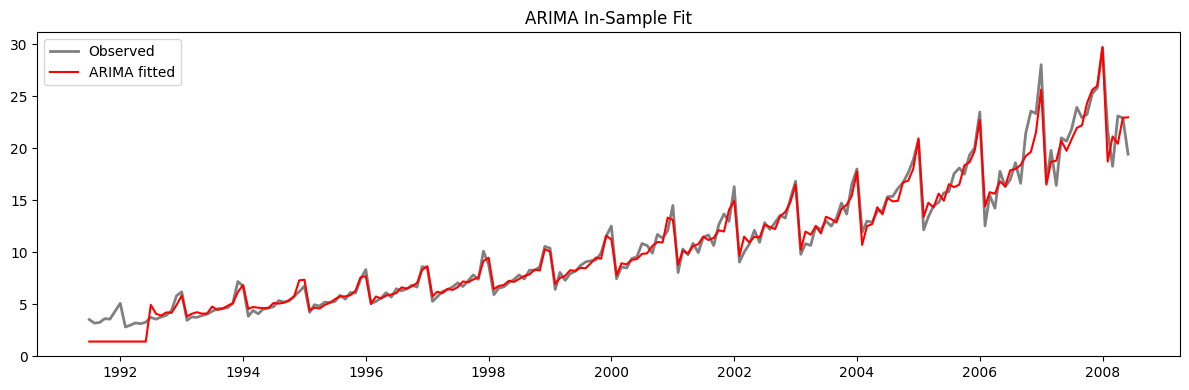

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# In-sample fitted values
fitted_values = pd.Series(
    smodel.predict_in_sample(),
    index=drug_data.index
)

plt.figure(figsize=(12, 4))
plt.plot(drug_data, label="Observed", linewidth=2, color = "grey")
plt.plot(fitted_values, label="ARIMA fitted",  color = "red")
plt.title("ARIMA In-Sample Fit")
plt.legend()
plt.tight_layout()
plt.show()

## 7.Prophet: Facebook's forecasting package

**Prophet** is an additive forecasting model developed by Facebook that decomposes a time series into:

$ y(t) = g(t) + s(t) + \varepsilon_t $

where:
- $g(t)$ = trend component (piecewise linear or logistic)
- $s(t)$ = seasonal component (Fourier series)
- $\varepsilon_t$ = noise

Key characteristics:
- Explicit modeling of **trend** and **seasonality**
- Robust to missing data and outliers
- Minimal manual tuning

In [42]:
from prophet import Prophet
import pandas as pd

def ensure_timestamp(s: pd.Series) -> pd.Series:
    """
    Convert a pandas Series to datetime64[ns].
    - If it's a Period dtype, convert via .dt.to_timestamp()
    - Otherwise use pd.to_datetime
    """
    if isinstance(s.dtype, pd.PeriodDtype):
        return s.dt.to_timestamp()
    return pd.to_datetime(s)

# 1) Prepare training data (Prophet requires ds as datetime64[ns])
prophet_train = training_df[["year", "Monthly Anomaly_global"]].copy()
prophet_train["ds"] = ensure_timestamp(prophet_train["year"])
prophet_train["y"] = prophet_train["Monthly Anomaly_global"]
prophet_train = prophet_train[["ds", "y"]].dropna()

# 2) Fit Prophet
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)
prophet_model.fit(prophet_train)

# 3) Prepare future dates for test horizon
future = test_df[["year"]].copy()
future["ds"] = ensure_timestamp(future["year"])
future = future[["ds"]].dropna().sort_values("ds").reset_index(drop=True)

# 4) Predict
prophet_pred = prophet_model.predict(future)[["ds", "yhat"]].rename(columns={"yhat": "prophet_forecast"})

test_df["prophet_forecast"] = prophet_pred["prophet_forecast"].to_numpy()


14:13:19 - cmdstanpy - INFO - Chain [1] start processing
14:13:19 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# 5) Plot (ensure timestamps for plotting too)
train_plot = training_df.copy()
test_plot = test_df.copy()
train_plot["year"] = ensure_timestamp(train_plot["year"])
test_plot["year"] = ensure_timestamp(test_plot["year"])

plot_forecast(
    train_plot,
    test_plot,
    forecast_col="prophet_forecast",
    title="Prophet Forecast vs Training and Test Data"
)


## Summary

To sum up, we compare the performance of all forecasts generated so far:

In [44]:
train_plot = (
    training_df[["year", "Monthly Anomaly_global"]]
    .assign(Series="Training data")
    .rename(columns={"Monthly Anomaly_global": "value"})
    [["year", "value", "Series"]]
)

# --- 2) True test in long format ---
test_true_plot = (
    test_df[["year", "Monthly Anomaly_global"]]
    .assign(Series="True (test)")
    .rename(columns={"Monthly Anomaly_global": "value"})
    [["year", "value", "Series"]]
)

# --- 3) Forecasts (already in long format with column name "value") ---
forecast_cols = [
    "naive_forecast",
    "ma_forecast",
    "ses_forecast",
    "holt_forecast",
    "arima_forecast",
    "seasonal_naive_forecast",
    "sarima_forecast",
    "auto_arima_forecast",
    "seasonal_auto_arima_forecast",
    "prophet_forecast",
]
available_forecasts = [c for c in forecast_cols if c in test_df.columns]

test_forecast_plot = (
    test_df[["year"] + available_forecasts]
    .melt(
        id_vars="year",
        value_vars=available_forecasts,
        var_name="Series",
        value_name="value"
    )
    [["year", "value", "Series"]]
)

plot_df = pd.concat([train_plot, test_true_plot, test_forecast_plot], ignore_index=True)

(
    ggplot(plot_df, aes(x="year", y="value", color="Series"))
    + geom_line(size=1)
    + labs(
        title="Temperature Forecast Comparison: Training, True Test, and All Forecasts",
        x="Year",
        y="Temperature Anomaly",
        color="Series"
    )
    + ggsize(1100, 500)
)


In [45]:
# --- 5) Accuracy table (MAE, RMSE) for all available forecasts ---
y_true = test_df["Monthly Anomaly_global"]

accuracy_df = pd.DataFrame({
    model: forecast_accuracy(y_true, test_df[model])
    for model in available_forecasts
}).T

accuracy_df = accuracy_df.sort_values("RMSE")
accuracy_df


,MAE,RMSE
holt_forecast,0.126630,0.158092
auto_arima_forecast,0.372805,0.413558
ses_forecast,0.433085,0.485099
naive_forecast,0.462014,0.513415
ma_forecast,0.504106,0.551598
prophet_forecast,0.557096,0.586667
seasonal_naive_forecast,0.517514,0.593560


The quite simple `holt` model perfoms best. Notably, we also see that the naive forecast performs better than the sophisticated prophet model. This underlines the importance of using naive baselines.

# Model diagnostics

After fitting a forecasting model, one crucial question remains:

> Is there information that the model has **not used?**



## Residual analysis

Residuals capture exactly this unexplained part.

For a forecast $\hat{y}_t$ and observation $y_t$, the residual is:

$ e_t = y_t - \hat{y}_t $


Residuals are the **diagnostic signal** of a forecasting model.




## Ideal Residual Behavior

A *good* forecasting model produces residuals that:

- fluctuate around **zero**
- show **no trend**
- show **no seasonality**
- show **no autocorrelation**
- have **constant variance**

In short:

> **Residuals should look like random noise.**

## What Residual Patterns Tell Us

Residuals are not just errors — they contain information.

| Residual pattern | What it indicates |
|---|---|
| Trend | Missing differencing / trend |
| Seasonality | Missing seasonal component |
| Autocorrelation | Dynamics not captured |
| Changing variance | Level-dependent volatility |
| Outliers | Structural breaks or shocks |



> 👉 Residuals tell you **how to improve the model**. **If residuals are structured, the model is incomplete.**

## Example: Residual analysis for the ARIMA model

Let's have a look at the residuals from the ARIMA model estimated using the `auto_arima()` method:

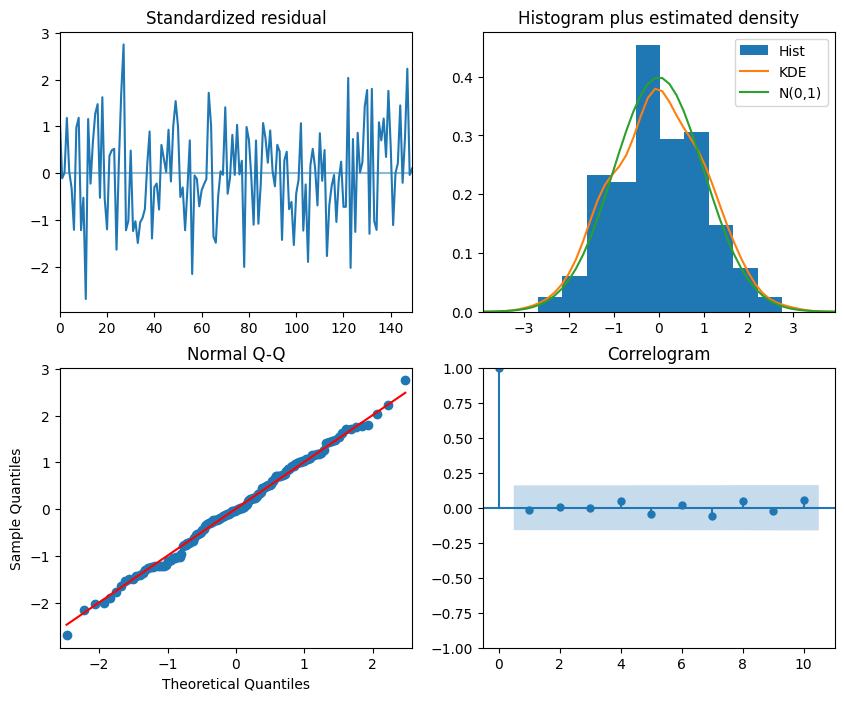

In [46]:
auto_model.plot_diagnostics(figsize=(10,8))
plt.show()

_Standardized residual:_ The residual errors seem to fluctuate around a __mean of zero__ and have a __uniform variance.__

_Histogram:_ The density plot suggest __a normal distribution.__

_Theoretical Quantiles:_ Mostly the dots __fall perfectly in line__ with the red line. Any significant deviations would imply the distribution is skewed.

_Correlogram:_ The Correlogram, (or ACF plot) shows the residual errors are __not autocorrelated__ with themselves. The ACF plot shows all correlations within the threshold limits (blue band) indicating that the residuals are behaving like white noise.

Overall, there seem __no patterns remaining__ in the residuals, so that the model appears to be a __good fit.__ 

# Further tasks in time-series analysis

## Time Series Classification
<img src='https://raw.githubusercontent.com/vhaus63/ids_data/main/ts_classification.png' style='width:40%; float:left;' />


The goal of this supervised learning task is to assign a specific __label or category to each time series__ based on its content or pattern. The classification is done according to predefined classes or categories. The model learns to predict the label of new, unseen time series based on patterns learned from the training data.

Examples:

- __Predictive maintenance:__ Is a machine is operating normally or has a fault?
- __Activity detection using wearables:__ Is a person running, swimming, sitting or sleeping?



__Common methods:__ Time Series Classification approaches frequently use a __nearest neighbor (NN) classifier__ coupled with a distance function. Particularly, the Dynamic Time Warping (DTW) distance when used with a NN classifier has been shown to be a very strong algorithm. Additionally to this, research has found different __Deep Neural Network Architectures__ to be very performant in this task.

__Further reading:__ Time series classification (Nielsen (2020) "Practical Time Series Analysis: Prediction with Statistics and Machine Learning", Chapter 9)

## Time Series Clustering
<img src='https://raw.githubusercontent.com/vhaus63/ids_data/main/clustering.png' style='width:50%; float:left;' />

Time Series Clustering on the other hand aims at __grouping similar time series into clusters__ without prior knowledge of the categories or labels. The data points are grouped based on their patterns or features. It is an unsupervised learning task.

Examples:
- Identifying similar households based on __clustering electricity consumption__
- Grouping sensor data from different machines in a factory into clusters based on similar operational patterns.

__Further reading:__  Time Series clustering (Nielsen (2020), Chapter 9)


## Forecasting Multiple Time Series

In the real world, we are often lucky enough to have __several time series in parallel__ that are presumably related to one another. 

__Vector Autoregression (VAR)__ is a multivariate forecasting algorithm that is used when two or more time series influence each other.Each variable is modeled as a linear combination of past values of itself and the __past values of other variables__ in the system. 

__Example macroeconomic dynamics:__ Inflation, Interest rate, GDP growth, Unemploymene evolve over time and influence each other simultaneously.

Futher reading:
- Forecasting multiple time series (Nielsen (2020), Chapter 6)
- [This](https://github.com/xxl4tomxu98/vector-autoregressive-model-wage-inflations/blob/main/VAR-model.ipynb) notebook.

## Outlook

This lecture focused on forecasting time series data using a variety of models. 

Beyond forecasting, time series analysis encompasses other exciting areas, such as Anomaly Detection and pattern recognition, offering diverse tools and methods to tackle real-world challenges. This lecture serves as a solid foundation for further exploration into these advanced topics.

# Related Content and further resources
 
* __Forecasting: Principles and Practice.__ A widely used, freely available textbook, including video explanations: https://otexts.com/fpp3/
* Overview of forecasting libraries [in Python](https://perma.cc/GEQ3-Q54X) and [R](https://perma.cc/HWY6-W2VU)
* [Twitter's Open Source Anomaly Detection Package](https://perma.cc/RV8V-PZXU)

<img src="https://github.com/GuntherGust/tds2_data/blob/main/images/d3.png?raw=true" style="width:80%; float:left;" />
